# PyTorch paper replication for Vision transformer

Turn the research paper into usable code.

### Get setup

Import already written code and libraries.

In [48]:
import os
print(os.getcwd())

D:\python_projects\Gym\pytorch


In [49]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.7.1+cu126
Torchvision version: 0.22.1+cpu


In [50]:
import torchinfo


from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [51]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Get data

Replicate the ViT architecture for FoodVisionMini.

In [52]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [53]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [54]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## Create datasets and dataloaders

In [55]:
from going_modular import data_setup
from torchvision import transforms

# Create image size
IMAGE_SIZE = 224  # ViT paper uses 224x224 images

#Create data transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [56]:
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2eb240040a0>,
 ['pizza', 'steak', 'sushi'])

In [57]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### Visualize a single image and its label



In [58]:
# Get a batch of images and labels
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label
image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

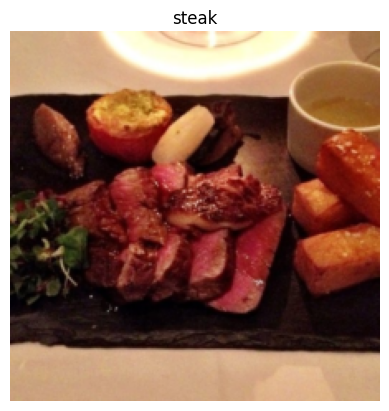

In [59]:
# PLot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])
plt.axis("off")

### Replicate ViT architecture: Overview

### Equation 1: Split data into patches and creating the class, position and patch embeddings

Layer = input -> function -> output

* Input shape = (224, 224, 3)
* Output shape = ()

In [60]:
# Create example values

height = 224
width = 224
color_channels = 3
patch_size = 16

# Number of patches
number_of_patches = (height // patch_size) * (width // patch_size)
number_of_patches

196

In [61]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
# Output shape
embedding_layer_output_shape = (number_of_patches, color_channels * patch_size**2)

embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196, 768))

### Turn a single image into patches.

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

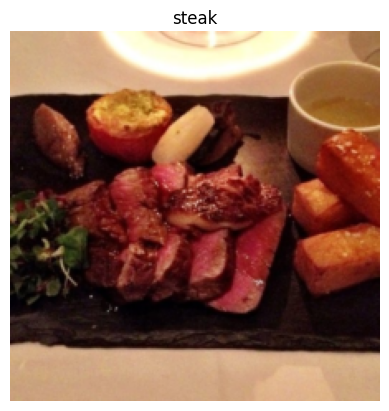

In [62]:
# View a single image
plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])
plt.axis("off")

In [63]:
image.shape

torch.Size([3, 224, 224])

Text(0.5, 1.0, 'Top-row of the image')

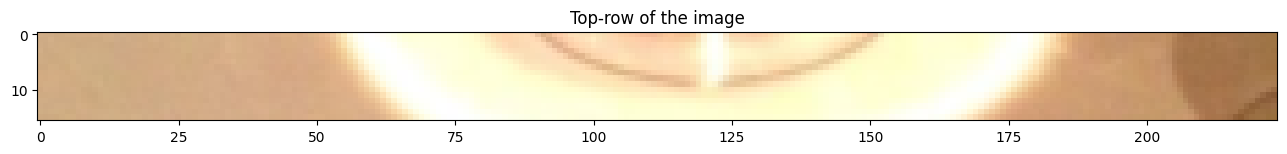

In [64]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)  # Change shape to (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])  # Plot the top-left patch
plt.title("Top-row of the image")

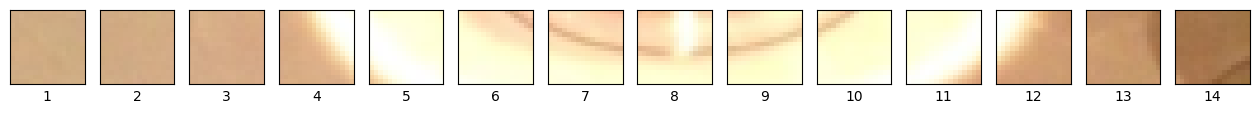

In [65]:
# Setup code to plot top row as patches

img_size = 224
patch_size = 16
number_of_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size."

# Create a series of subplots to visualize patches
fig, axes = plt.subplots(nrows=1, 
                         ncols=int(number_of_patches),
                         sharex=True,
                         sharey=True,
                         figsize=(patch_size, patch_size))


for i, patch in enumerate(range(0, img_size, patch_size)):
    axes[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axes[i].set_xlabel(i+1)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

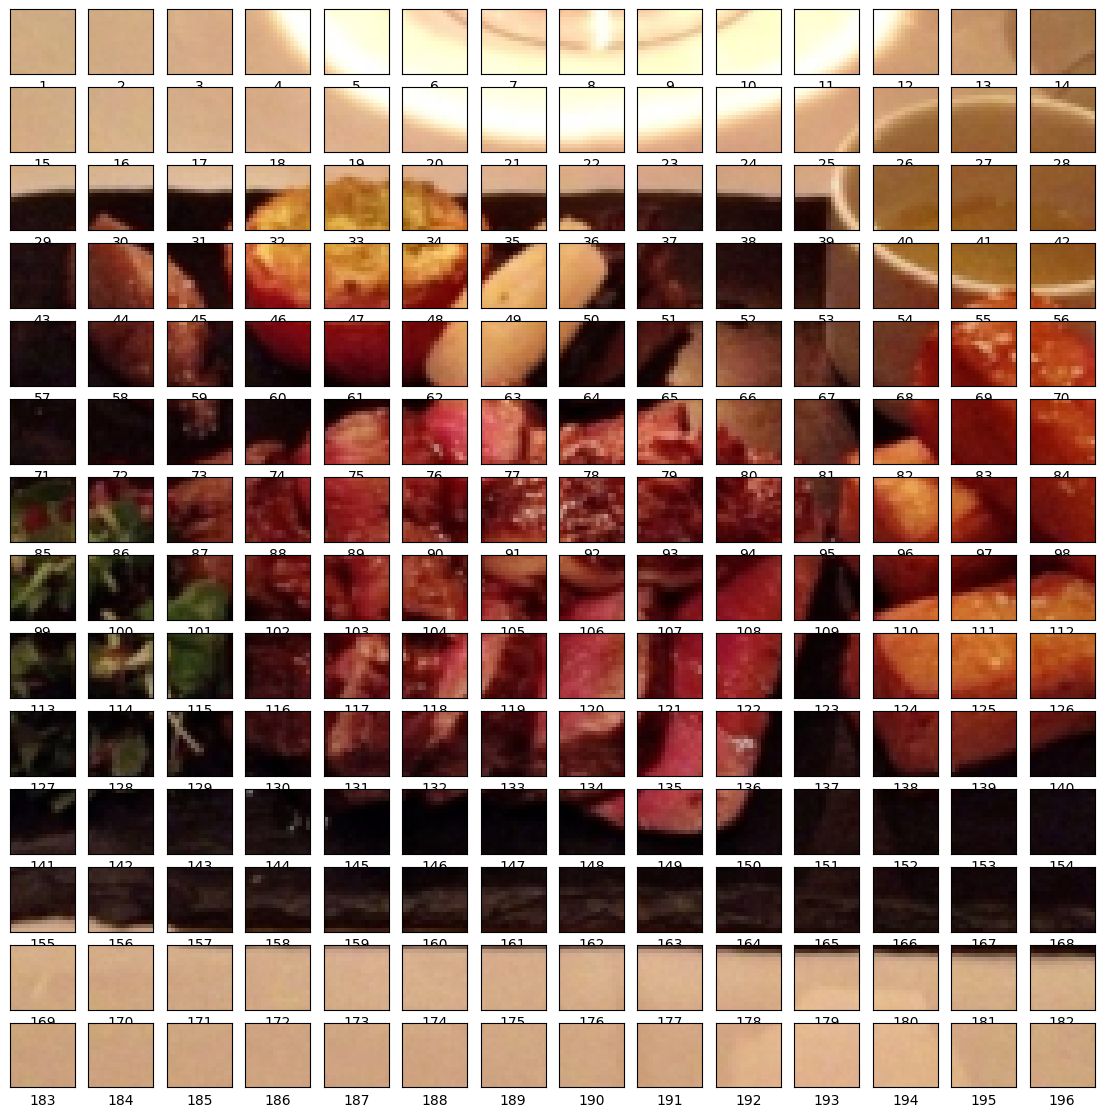

In [66]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
number_of_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size."

# Create a series of subplots to visualize patches
fig, axes = plt.subplots(
    nrows=int(number_of_patches),
    ncols=int(number_of_patches),
    figsize=(number_of_patches, number_of_patches),
    sharex=True,
    sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axes[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                         patch_width:patch_width+patch_size, :])
        axes[i, j].set_xlabel(f"{i * int(number_of_patches) + j + 1}")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
                         

### Creating image patches and transforming them into embeddings.

In [67]:
# Create conv2d layer to turn an image into patches
from torch import nn

# Set the patch size
patch_size = 16

# Create a convolutional layer to extract patches
conv2d = nn.Conv2d(
    in_channels=3,  # Number of color channels in the image
    out_channels=3 * patch_size**2,  # Each patch will have 3 * patch_size^2 features
    kernel_size=patch_size,  # Patch size
    stride=patch_size,  # Move by patch size to get non-overlapping patches
    padding=0,  # No padding needed for non-overlapping patches
)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

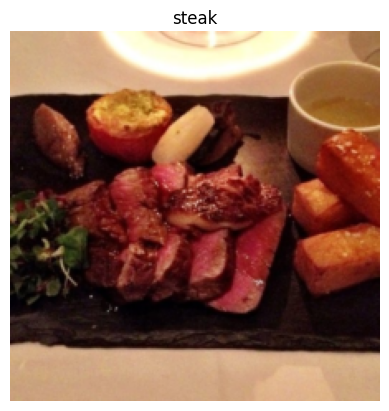

In [68]:
# View single image
plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])
plt.axis("off")

In [69]:
# Pass the image through the conv2d layer
image_out_of_conv = conv2d(image.unsqueeze(0))  # Add batch dimension
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [70]:
flatten = image_out_of_conv.flatten(2,3)
flatten.shape  # Flatten the output to (batch_size, num_patches, patch_features)

torch.Size([1, 768, 196])

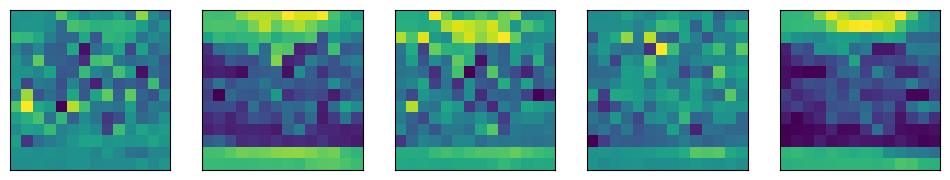

In [71]:
import random
random_indexes = random.sample(range(0, 768), k=5)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, index in enumerate(random_indexes):
    image_conv_map = image_out_of_conv[0, index, :, :]
    axes[i].imshow(image_conv_map.squeeze().detach().numpy())
    axes[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### Flatten the embeddings using torch.nn.Flatten.

In [72]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [73]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

flatten_layer(image_out_of_conv).shape  # Flatten the output to (batch_size, num_patches, patch_features)

torch.Size([1, 768, 196])

Image shape: torch.Size([3, 224, 224])
Image out of conv shape: torch.Size([1, 768, 14, 14])
Image out of conv flattened shape: torch.Size([1, 768, 196])


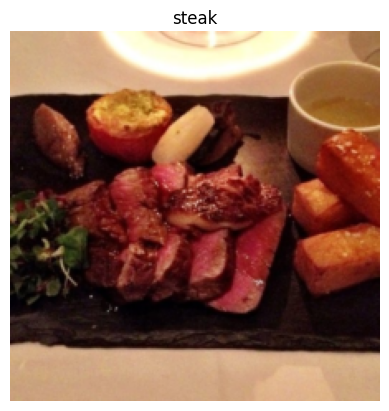

In [74]:
# Put everything together

plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])
plt.axis("off")
print(f"Image shape: {image.shape}")

# Turn the image into patches
image_out_of_conv = conv2d(image.unsqueeze(0))  # Add batch dimension
print(f"Image out of conv shape: {image_out_of_conv.shape}")

# Flatten the output
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Image out of conv flattened shape: {image_out_of_conv_flattened.shape}")

In [77]:
# Rearrange the output of flatten layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)  # (batch_size, num_patches, patch_features)
print(f"Image out of conv flattened rearranged shape: {image_out_of_conv_flattened_permuted.shape}")

Image out of conv flattened rearranged shape: torch.Size([1, 196, 768])


Single flattened feature map shape: torch.Size([1, 196])


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

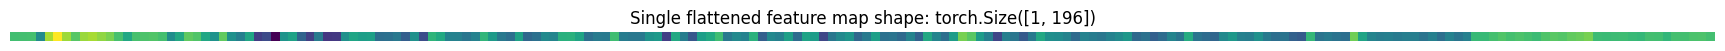

In [78]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

print(f"Single flattened feature map shape: {single_flattened_feature_map.shape}")

#Plot the single flattened feature map visualization
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Single flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis("off")